In [1]:
import random
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings("ignore")
rs = np.random.RandomState(0)
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
from visualize import *
from calibration import *
from collections import defaultdict
from tqdm import tqdm
from spline import *


NUM_BINS = 10
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 5
NUM_RUN = 50
# limit to the cases when the number of samples is less than 1000
NUM_SAMPLES = [20, 50, 100] + [50 * _ for _ in range(3, 20)] 
print len(NUM_SAMPLES)
METHOD_NAME = "binary_spline"

20


try out the PyGAM package (e.g., Logistic GAM with splines) for one or more of our datasets (e.g., p(y=1 | max_k s_k(x)) for calibration, or Accuracy( g (x) ) versus g(x) where g(x) is brightness - to get a sense whether this approach is a bit more robust than (say) GP classification methods.

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
DATASET = "cifar100_predictions_dropout"
data = np.genfromtxt("data/%s.txt" % DATASET)# 10000*101
score = data[:,1:]
Y_predict = np.argmax(score, axis=1)
Y_true = data[:,0]

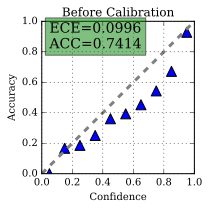

In [3]:
fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ece, acc, ax = reliability_plot(ax, score, Y_true, NUM_BINS)
ax.set_title("Before Calibration")
fig.tight_layout()

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


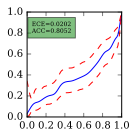

In [4]:
# feed all data into spline regression
fig, ax = plt.subplots()
fig.set_figheight(2)
fig.set_figwidth(2)
ece, acc, ax, confi = spline_classification_plot(ax,
                           np.max(score, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1)
fig.tight_layout()

# active learning

In [5]:
training_list = [i for i in range(10000)]
subset_init = np.random.choice(training_list, size = NUM_SAMPLES[0], replace = False).tolist()

In [6]:
def active_learning(acq_func, subset_init, candidate_list, NUM_SAMPLES):
    
    ece_dict = dict()
    acc_dict = dict()
    subset_list = []

    fig, ax = plt.subplots(nrows=5, ncols=5)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    
    for idx in range(len(NUM_SAMPLES)):
        if idx == 0:
            subset_list += subset_init
        else:
            n_inc = NUM_SAMPLES[idx] - NUM_SAMPLES[idx-1]
            subset_list += acq_func(n_inc, candidate_list, subset_list, confi)
        ece, acc, ax[idx / NUM_COL, idx % NUM_COL], confi = \
                                    spline_classification_plot(ax[idx / NUM_COL, idx % NUM_COL],
                                    np.max(score[subset_list], axis=1).reshape(-1, 1),
                                    np.array(Y_true == Y_predict)[subset_list] * 1)
        ax[idx / NUM_COL, idx % NUM_COL].set_xlabel("N=%d" % NUM_SAMPLES[idx])
        ece_dict[NUM_SAMPLES[idx]] = ece[0]
        acc_dict[NUM_SAMPLES[idx]] = acc
    fig.tight_layout()
    
    return ece_dict, acc_dict

def acq_random(n_inc, candidate_list, subset_list, confi=None):
    weights = np.array([1.0 for _ in candidate_list])
    weights[subset_list] = 0
    p = weights / weights.sum()
    return np.random.choice(candidate_list, size = n_inc, replace = False, p = p).tolist()


def acq_active_prb(n_inc, candidate_list, subset_list, confi):
    confi = sigmoid(confi) # 100 * 1
    uncertainty = confi[:,1] - confi[:, 0]
    digitized = np.digitize(np.max(score, axis=1).reshape(-1, 1), 
                            np.linspace(0, 1, 100)) -1
    weights = uncertainty[digitized]
    weights[subset_list] = 0
    p = weights[:,0] / weights[:,0].sum()
    return np.random.choice(candidate_list, size = n_inc, replace = False, p = p).tolist()

def acq_active_dtm(n_inc, candidate_list, subset_list, confi):
    import heapq
    confi = sigmoid(confi) # 100 * 1
    uncertainty = confi[:,1] - confi[:, 0]
    digitized = np.digitize(np.max(score, axis=1).reshape(-1, 1), 
                            np.linspace(0, 1, 100)) -1
    weights = uncertainty[digitized]
    weights[subset_list] = 0
    return heapq.nlargest(n_inc, range(len(weights)), weights.__getitem__)

def acq_active_bin(n_inc, candidate_list, subset_list, confi=None):
    import heapq
    confi = sigmoid(confi) # 100 * 1
    uncertainty = confi[:,1] - confi[:, 0]
    digitized = np.digitize(np.max(score, axis=1).reshape(-1, 1), 
                            np.linspace(0, 1, 100)) -1
    weights = uncertainty[digitized]
    weights[subset_list] = 0
    return heapq.nlargest(n_inc, range(len(weights)), weights.__getitem__)

### randomly select datapoints and feed to spline regression

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

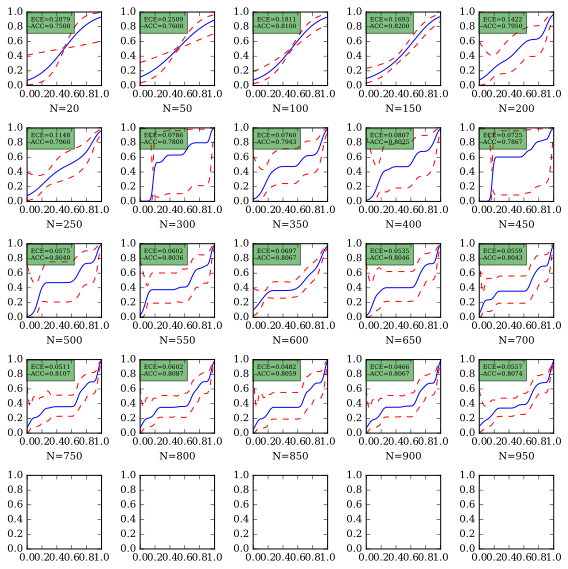

In [7]:
ece_random, acc_random =  active_learning(acq_random, subset_init, training_list, NUM_SAMPLES)

### actively select datapoints and feed into spline regression

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

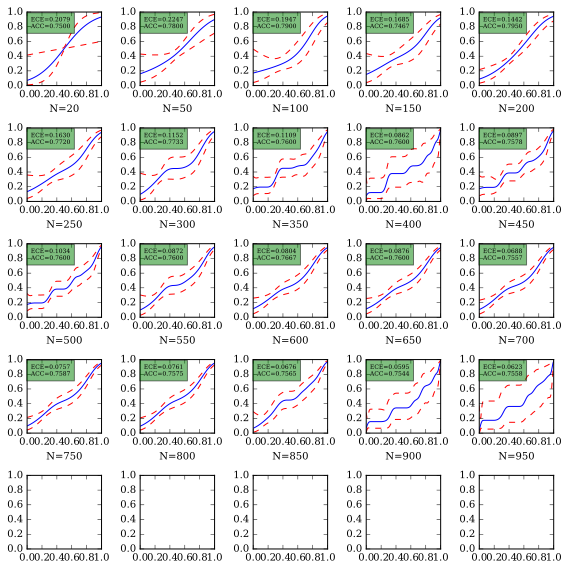

In [8]:
# reweight datapoints acccording to uncertainty
ece_active_prb, acc_active_prb =  active_learning(acq_active_prb, subset_init, training_list, NUM_SAMPLES)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

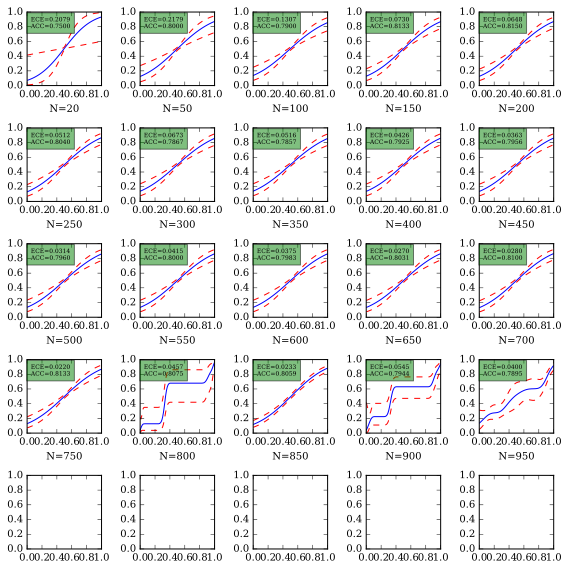

In [9]:
## select data points with highest uncertainty
ece_active_dtm, acc_active_dtm =  active_learning(acq_active_dtm, subset_init, training_list, NUM_SAMPLES)

### Bayesian binning for active learning

## Compare different acquisition methods in a single run

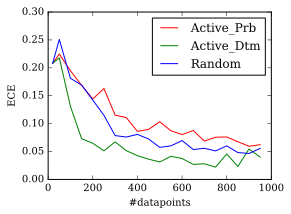

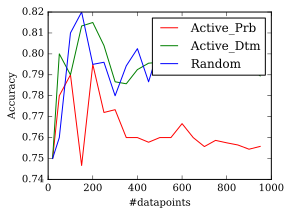

In [10]:
plt.figure(figsize = (4,3))
plt.plot(NUM_SAMPLES, 
             [ece_active_prb[_] for _ in NUM_SAMPLES], 
             c = 'r', label="Active_Prb")
plt.plot(NUM_SAMPLES, 
             [ece_active_dtm[_] for _ in NUM_SAMPLES], 
             c = 'g', label="Active_Dtm")
plt.plot(NUM_SAMPLES, 
             [ece_random[_] for _ in NUM_SAMPLES], 
             c = 'b', label="Random")
plt.xlabel("#datapoints")
plt.ylabel("ECE")
plt.legend()
plt.figure(figsize = (4,3))
plt.plot(NUM_SAMPLES, 
             [acc_active_prb[_] for _ in NUM_SAMPLES], 
             c = 'r', label="Active_Prb")
plt.plot(NUM_SAMPLES, 
             [acc_active_dtm[_] for _ in NUM_SAMPLES], 
             c = 'g', label="Active_Dtm")
plt.plot(NUM_SAMPLES, 
             [acc_random[_] for _ in NUM_SAMPLES],
             c = 'b', label="Random")
plt.xlabel("#datapoints")
plt.ylabel("Accuracy")
plt.legend()

## Multiple runs to get errorbars

In [11]:
######### run spline_run.py for a given dataset for multiple runs.
# results will be written to output/DATASET with filenames ece_random.csv, 
# ece_active.csv, acc_random.csv, acc_active.csv.

# disij@datalab-5 22:19:44 ~/projects/sandbox/nn_assessor
# python spline_run.py


######### load the results
def loadcsv(filename):
    """
    INPUT:
        filename:  a csv file. can be ece_random, ece_active, acc_random, 
                    acc_active in this case.
    OUTPUT:
        result_dict: defaultdict(list). can be ece_random, ece_active, 
                    acc_random, acc_active in this case.
    """
    import csv
    result_dict = defaultdict(list)
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split(",")
            result_dict[int(line[0])].append([float(_) for _ in line[1:]])
    return result_dict

ece_random_multi_run = loadcsv("output/%s/ece_random.csv" % DATASET)
acc_random_multi_run = loadcsv("output/%s/acc_random.csv" % DATASET)
ece_active_prb_multi_run = loadcsv("output/%s/ece_active_prb.csv" % DATASET)
acc_active_prb_multi_run = loadcsv("output/%s/acc_active_prb.csv" % DATASET)
ece_active_dtm_multi_run = loadcsv("output/%s/ece_active_dtm.csv" % DATASET)
acc_active_dtm_multi_run = loadcsv("output/%s/acc_active_dtm.csv" % DATASET)

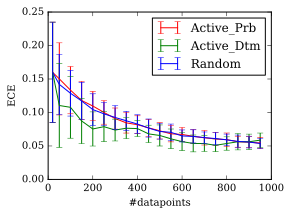

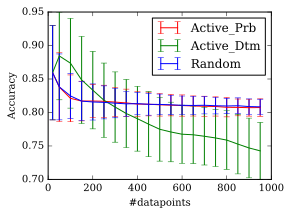

In [12]:
plt.figure(figsize = (4,3))
plt.errorbar(NUM_SAMPLES, 
             [np.mean(ece_active_prb_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(ece_active_prb_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'r', label="Active_Prb")
plt.errorbar(NUM_SAMPLES, 
             [np.mean(ece_active_dtm_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(ece_active_dtm_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'g', label="Active_Dtm")
plt.errorbar(NUM_SAMPLES, 
             [np.mean(ece_random_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(ece_random_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'b', label="Random")
plt.xlabel("#datapoints")
plt.ylabel("ECE")
plt.legend()
plt.figure(figsize = (4,3))
plt.errorbar(NUM_SAMPLES, 
             [np.mean(acc_active_prb_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(acc_active_prb_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'r', label="Active_Prb")
plt.errorbar(NUM_SAMPLES, 
             [np.mean(acc_active_dtm_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(acc_active_dtm_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'g', label="Active_Dtm")
plt.errorbar(NUM_SAMPLES, 
             [np.mean(acc_random_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(acc_random_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'b', label="Random")
plt.xlabel("#datapoints")
plt.ylabel("Accuracy")
plt.legend()